In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import aurum
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [2]:
# Fonte -> https://github.com/scikit-learn/scikit-learn/issues/20051

def export_dict(clf, feature_names=None):
    tree = clf.tree_
    if feature_names is None:
        feature_names = clf.feature_names_in_ # Pequena alteração no número de features
    
    # Build tree nodes
    tree_nodes = []
    for i in range(tree.node_count):
        if (tree.children_left[i] == tree.children_right[i]):
            tree_nodes.append(
                clf.classes_[np.argmax(tree.value[i])]
            )
        else:
            tree_nodes.append({
                "feature": feature_names[tree.feature[i]],
                "value": tree.threshold[i],
                "left": tree.children_left[i],
                "right": tree.children_right[i],
            })
    
    # Link tree nodes
    for node in tree_nodes:
        if isinstance(node, dict):
            node["left"] = tree_nodes[node["left"]]
        if isinstance(node, dict):
            node["right"] = tree_nodes[node["right"]]
    
    # Return root node
    return tree_nodes[0]

Referência:

- https://plotly.com/python/tree-plots/

- Possui uma dependência com o igraph, um pacote utilizado para visualização de grafos
- Nele temos uma classe para plotar arvores de decisão com a classe Tree
- Para determinarmos o número de vertices de childrens do plot, precisamos importar um modelo pre existente ou treinar um.
- Modelos de arvore possuem o objeto Tree sobre o capô, podendo ser acessado através do atributo tree_ de um modleo pré carregado.

In [3]:
tree_obj = joblib.load('VS07/Silver - ABEV3.SA.sav').best_estimator_.tree_
tree_model = joblib.load('VS07/Silver - ABEV3.SA.sav').best_estimator_

/home/sors/.cache/pypoetry/virtualenvs/aurum-VUpOJaU5-py3.9/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/sors/.cache/pypoetry/virtualenvs/aurum-VUpOJaU5-py3.9/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
import re
from sklearn.tree import export_graphviz, export_text

tree_text = export_text(tree_model)

# A maior das gambiarras a seguir:
regex_result = re.findall('(feature_[0-9]*)|class: ([0-9])', tree_text)

df = pd.DataFrame(regex_result, columns=['Feature',
                                        'Class'
                                        ])
df['Consolidado'] = df['Feature'] + df['Class']
df.head()

,Feature,Class,Consolidado
0,feature_0,,feature_0
1,feature_7,,feature_7
2,,0,0
3,feature_7,,feature_7
4,,0,0


Referência: 
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

Atributos do objeto Tree

In [5]:
n_nodes = tree_obj.node_count
feature = tree_obj.feature
threshold = tree_obj.threshold

sample_by_node = pd.DataFrame(tree_obj.value[:,0],columns=['Class_0', 'Class_1'])
result = pd.Series([1 if x > y else 0 for x,y in zip(sample_by_node.Class_1, sample_by_node.Class_0)])

features_naming = pd.DataFrame(feature, columns=['featureIndex'])
features_naming['featureNames'] = [tree_model.feature_names_in_[x] if x != -2 else np.nan for x in features_naming['featureIndex'].to_list()]
features_naming.loc[features_naming['featureNames'].isna(), 'featureNames'] = result[features_naming.featureNames.isna()]


In [43]:
import igraph
from igraph import Graph, EdgeSeq

nr_vertices = n_nodes
#v_label = list(map(str, range(nr_vertices)))
v_label = features_naming.featureNames.to_list()
G = Graph.Tree(nr_vertices, 2) # 2 stands for children number
lay = G.layout_bipartite()

position = {k: lay[k] for k in range(nr_vertices)}
Y = [lay[k][1] for k in range(nr_vertices)]
M = max(Y)

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0], None]
    Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None]

labels = v_label

InternalError: Error at src/_igraph/attributes.c:1700: No such attribute. -- Invalid value

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none',
                   #line_symbol='square'
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='diamond-wide',
                                size=60,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

In [35]:
def make_annotations(pos, text, font_size=10, font_color='rgb(250,250,250)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = []
    for k in range(L):
        annotations.append(
            dict(
                text=labels[k], # or replace labels with a different list for the text within the circle
                x=pos[k][0], y=2*M-position[k][1],
                xref='x1', yref='y1',
                font=dict(color=font_color, size=font_size),
                showarrow=False)
        )
    return annotations

In [36]:
axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Tree with Reingold-Tilford Layout',
              annotations=make_annotations(position, v_label),
              font_size=12,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)',
              autosize=False,
              width=1000,
              height=900
              )
fig.show()

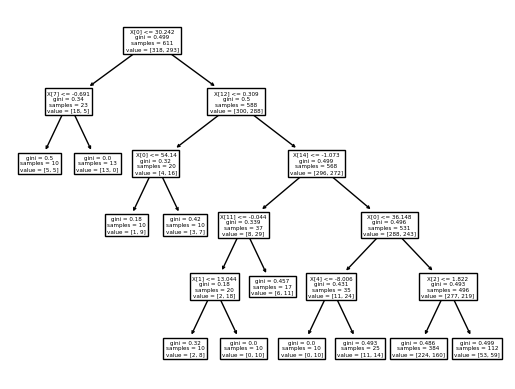

In [24]:
plot_tree(tree_model);

In [10]:
features_naming

,featureIndex,featureNames
0,0,RSI_14
1,7,EMA_9_DISTANCE
2,-2,0
3,-2,0
4,12,ATRr_5
5,0,RSI_14
6,-2,1
7,-2,1
8,14,OBV_ROC_14
9,11,SLOPE_3
